# Восстановление золота из руды

# Описание проекта

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:

- `gold_industry_train.csv` — обучающая выборка;

- `gold_industry_test.csv` — тестовая выборка;

- `gold_industry_full.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, необходимо проверить их на корректность.

# Описание данных

#### Технологический процесс

- `Rougher feed` — исходное сырье

- `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant

- `Xanthate` — ксантогенат (промотер, или активатор флотации)

- `Sulphate` — сульфат (на данном производстве сульфид натрия)

- `Depressant` — депрессант (силикат натрия)

- `Rougher process` (англ. «грубый процесс») — флотация

- `Rougher tails` — отвальные хвосты

- `Float banks` — флотационная установка

- `Cleaner process` — очистка

- `Rougher Au` — черновой концентрат золота

- `Final Au` — финальный концентрат золота

#### Параметры этапов

- `air amount` — объём воздуха

- `fluid levels` — уровень жидкости

- `feed size` — размер гранул сырья

- `feed rate` — скорость подачи

#### Наименование признаков

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`
Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

- `rougher` — флотация

- `primary_cleaner` — первичная очистка

- `secondary_cleaner` — вторичная очистка

- `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

- `input` — параметры сырья

- `output` — параметры продукта

- `state` — параметры, характеризующие текущее состояние этапа

- `calculation` — расчётные характеристики

In [1]:
#!pip install sweetviz

In [2]:
# Подключение библиотек

import warnings

import numpy as np
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression # линейная регрессия 
from sklearn.ensemble import RandomForestRegressor # случайный лес
from sklearn.dummy import DummyRegressor # для проверки модели на адекватность

from sklearn.model_selection import GridSearchCV # для поиска по сетке наил. параметров

from sklearn.metrics import mean_absolute_error as mae, make_scorer # метрики

# Настройки
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Константы

STATE = 123 # значение для параметра random_state

In [4]:
# Функция для формирования информационных отчетов по каждому региону

def inform_report(list_df):
    mark = ['train', 'test', 'full']
    list_reports = []
    list_names = []
    
    for num in range(len(list_df)):
        
        title = 'Gold_industry_' + mark[num]
        report = sv.analyze([list_df[num], title])
        report_name = 'Common_analysis_' + mark[num] + '.html'
        
        list_reports.append(report)
        list_names.append(report_name)
    
    return dict(zip(list_names, list_reports))

In [5]:
# Функция для расчёта эффективности обогащения

def recovery(C, F, T):
    return (C * (F - T)) / (F * (C - T)) * 100

## Подготовка данных

In [6]:
# Загрузка данных

try:
    df_train = pd.read_csv('gold_industry_train.csv')
    df_test = pd.read_csv('gold_industry_test.csv')
    df_full = pd.read_csv('gold_industry_full.csv')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv')
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv')
    
df_list = [df_train, df_test, df_full]

In [7]:
# Формируем отчёты по каждому набору данных

for key, value in inform_report(df_list).items():
    value.show_html(key)

Начальные наблюдения на основе отчётов:

Количество строк и столбцов полной выборки данных: `19439` и `87`, соответственно. Все признаки, за исключением признака `date`, являются численными. Признак `date` содержит дату и время получения информации, однако имеет тип `text`, следует изменить тип на `datetime`. Пропуски в данных есть (отдельно стоит отметить, что в целевых признаках `rougher.output.recovery` и `final.output.recovery` пропусков нет). Полных дубликатов нет.

Количество строк обучающей выборки `14579`, что состовляет приблизительно 75% от полного набора данных. Количество строк тестовой выборки `4860`, что составляет около 25% полного набора данных, также, тестовая выборка содержит только `53` признака (против `87` в полном наборе).

Наблюдается мультиколлинеарность некоторых признаков (коэффициент корреляции Пирсона близок к единице).

#### Проверим, что эффективность обогащения рассчитана правильно:

(вычислим её на обучающей выборке для признака `rougher.output.recovery` и найдём `MAE` между полученным значением и значением признака)

Формула для расчёта: $$Recovery=\frac{C\times(F - T)}{F\times(C - T)}\times 100\%$$

где

`C` — доля золота в концентрате после флотации/очистки;

`F` — доля золота в сырье/концентрате до флотации/очистки;

`T` — доля золота в отвальных хвостах после флотации/очистки.

In [8]:
# Расчёт эффективности обогащения

rougher_output_recovery = recovery(df_train['rougher.output.concentrate_au'],
                                   df_train['rougher.input.feed_au'], 
                                   df_train['rougher.output.tail_au'])

In [9]:
# Сравнение со значением признака по метрике

mae(rougher_output_recovery, df_train['rougher.output.recovery'])

9.83758577644259e-15

Так как средняя абсолютная ошибка между значениями близка к нулю, можно сделать вывод, что эффективность обогащения в данных рассчитана верно.

#### Проанализируем признаки, недоступные в тестовой выборке:

In [11]:
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют признаки, описывающие параметры продукта `output` на всех стадиях технологического процесса, и расчетные характеристики `calculation`. Возможно данные параметры рассчитываются значительно позже и потому недоступны. Перед обучением модели будет логично удалить данные признаки.

#### Предобработка данных:

In [12]:
# Изменяем тип данных признака date

for df in df_list:
    df['date'] = pd.to_datetime(df['date'])

In [13]:
# Смотрим более подробно в каких признаках обучающей выборки есть пропуски

df_train.isna().agg(['sum', 'mean']).T.query('sum > 0').sort_values(by='sum', ascending=False)

,sum,mean
secondary_cleaner.output.tail_sol,920.0,0.063104
rougher.state.floatbank10_e_air,429.0,0.029426
rougher.input.floatbank11_xanthate,407.0,0.027917
primary_cleaner.output.concentrate_sol,265.0,0.018177
final.output.concentrate_sol,192.0,0.013170
rougher.input.feed_size,101.0,0.006928
secondary_cleaner.state.floatbank2_a_air,94.0,0.006448
primary_cleaner.output.concentrate_pb,88.0,0.006036
rougher.input.feed_sol,77.0,0.005282
final.output.tail_pb,75.0,0.005144


In [14]:
# самая поздняя дата

df_train['date'].sort_values().tail()

14574   2017-12-09 09:59:59
14575   2017-12-09 10:59:59
14576   2017-12-09 11:59:59
14577   2017-12-09 12:59:59
14578   2017-12-09 13:59:59
Name: date, dtype: datetime64[ns]

In [15]:
# самая ранняя дата

df_test['date'].sort_values().head()

0   2017-12-09 14:59:59
1   2017-12-09 15:59:59
2   2017-12-09 16:59:59
3   2017-12-09 17:59:59
4   2017-12-09 18:59:59
Name: date, dtype: datetime64[ns]

Видно, что данные в обучающей выборке собраны до поступления данных в тестовую (самая поздняя дата в обучении меньше самой ранней даты в тесте), заполним пропуски, используя предыдущие известные значения:

In [16]:
# Список признаков, которых нет в тестовом наборе данных

unnecessary_features = list(set(df_train.columns) - set(df_test.columns))

In [17]:
for features in df_train.columns:
    if features not in unnecessary_features:
        df_train[features] = df_train[features].fillna(method='ffill')

In [18]:
# Проверка

df_train.isna().agg(['sum', 'mean']).T.query('sum > 0').sort_values(by='sum', ascending=False)

,sum,mean
secondary_cleaner.output.tail_sol,920.0,0.063104
primary_cleaner.output.concentrate_sol,265.0,0.018177
final.output.concentrate_sol,192.0,0.013170
primary_cleaner.output.concentrate_pb,88.0,0.006036
final.output.tail_pb,75.0,0.005144
primary_cleaner.output.tail_sol,45.0,0.003087
rougher.output.concentrate_sol,18.0,0.001235
primary_cleaner.output.tail_pb,6.0,0.000412
final.output.tail_sol,5.0,0.000343
secondary_cleaner.output.tail_pb,4.0,0.000274


## Анализ данных

Посмотрим, как меняется концентрация металлов (`Au`, `Ag`, `Pb`) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения?

In [19]:
# Сформируем список признаков, сгруппированных по виду металла, для анализа и визуализации

features_exploration = ['rougher.input.feed_', 'rougher.output.concentrate_', 
                        'primary_cleaner.output.concentrate_', 'final.output.concentrate_']


features_me = []

for el in ['au', 'ag', 'pb']:
    features = []
    
    for feature in features_exploration:
        features.append(feature+el)
    
    features_me.append(features) # список списков признаков, сгруппиров. по видам металлов

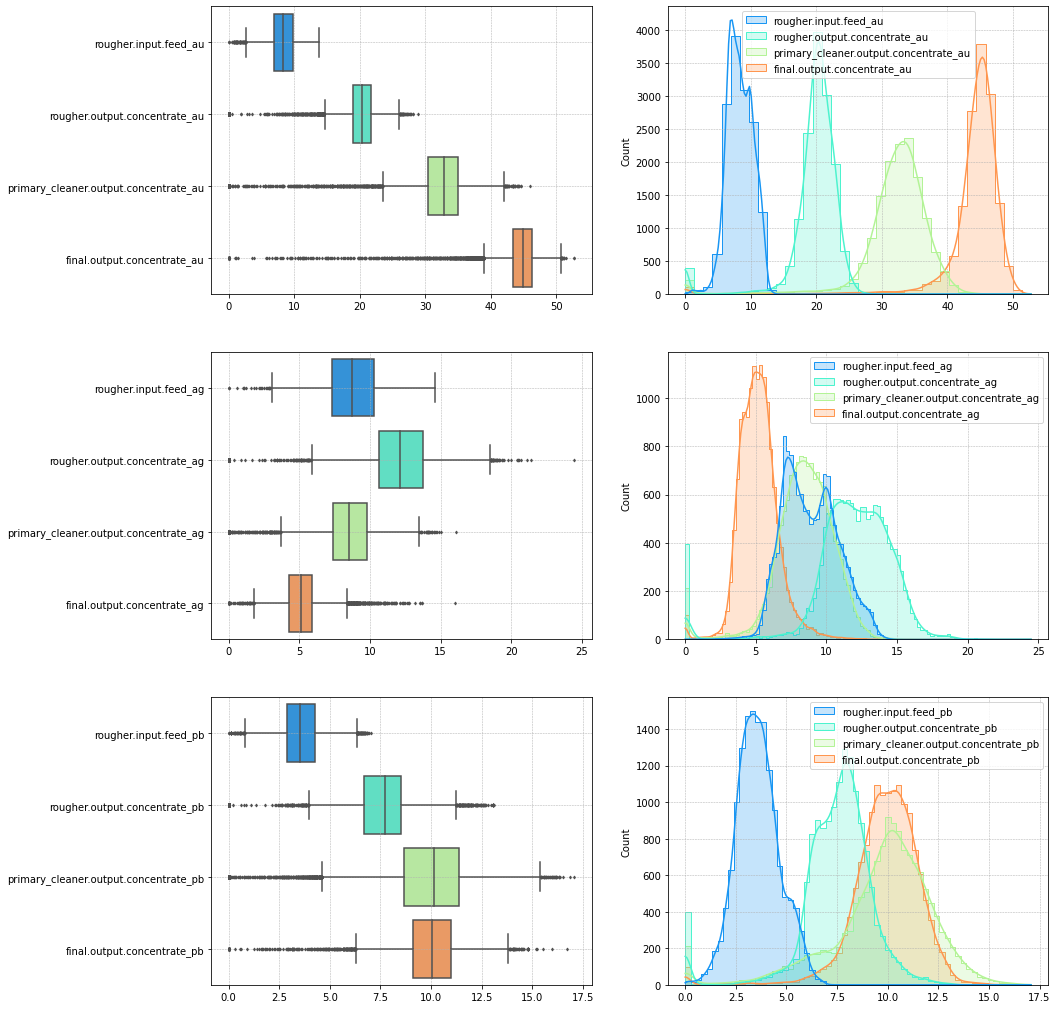

In [20]:
# Визуализация

fig, ax = plt.subplots(3, 2, figsize=(15, 18))

for i, feature in enumerate(features_me):
    
    plt.subplot(3, 2, 2*i + 1)
    ax = sns.boxplot(data=df_train[feature], fliersize=2, orient='h', palette='rainbow')
    ax.grid(linewidth = 0.5, linestyle = '--')
    
    plt.subplot(3, 2, 2*i + 2)
    ax = sns.histplot(df_train[feature], kde=True, element='step', palette='rainbow')
    ax.grid(linewidth = 0.5, linestyle = '--')

Надо что-то делать со скачками в нуле? 🤔

In [21]:
# Удаляем аномальные нулевые значения в признаках концентрации металлов (Au, Ag, Pb, Sol) на различных этапах

features_exploration = ['rougher.input.feed_', 'rougher.output.concentrate_', 
                        'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

for el in ['au', 'ag', 'pb', 'sol']:
    for feature in features_exploration:
        df_train = df_train[df_train[feature+el] != 0]

In [22]:
# Для проверки, что всё сработало

anomalies = []
for el in ['au', 'ag', 'pb', 'sol']:
    for feature in features_exploration:
        anomalies.append(feature+el)
        
for anomaly in anomalies:
    display((df_train[anomaly] == 0).any())

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

False

#### Вывод:

Ориентируясь на медианные значения показателей и гистограммы, можно сказать, что:
 - концентрация `Au` увеличивается примерно на 12% на каждом из этапов обработки, диапазон возможных значений расширается от этапа к этапу;
 - концентрация `Ag` увеличивается в процессе флотации, а вот дальнейшая обработка приводит к уменьшению концентрации, причём, к завершению процесса обработки уровень концентрации меньше, чем до её начала;
 - концентрация `Pb` увеличивается вплоть до второго этапа очистки, после, величина концентрации остается прииблизительно на одном уровне, среднее значение показателя в диапазоне от 7.5% до 12.5%.

Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [23]:
df_train['rougher.input.feed_size'].describe()

count    13988.000000
mean        59.169247
std         23.073101
min          0.049194
25%         47.361677
50%         54.589417
75%         64.523043
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [24]:
df_test['rougher.input.feed_size'].describe()

count    4816.000000
mean       59.113400
std        19.125122
min         0.046369
25%        47.596984
50%        55.509481
75%        66.661547
max       363.989699
Name: rougher.input.feed_size, dtype: float64

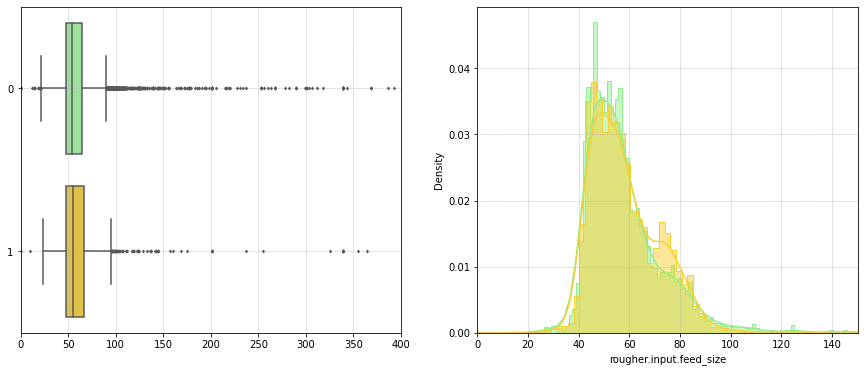

In [25]:
# Визуальзация

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1, 2, 1)
colors = ['#90EE90', '#F8D030']
ax = sns.boxplot(data=[df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']], 
                                                         fliersize=2, orient='h', palette=colors)
ax.grid(linewidth = 0.5, linestyle = '--')
plt.xlim(0, 400)
    
plt.subplot(1, 2, 2)
ax = sns.histplot(df_train['rougher.input.feed_size'], binrange=(0, 150), 
                  kde=True, element='step', color='#90EE90', stat='density', common_norm=False) 
ax = sns.histplot(df_test['rougher.input.feed_size'], binrange=(0, 150), 
                  kde=True, element='step', color='#F8D030', stat='density', common_norm=False) 
ax.grid(linewidth = 0.5, linestyle = '--')
plt.xlim(0, 150)

plt.show()

#### Вывод:

Характер распределений размера гранул на обучающей и тестовой выборках, а также статистики отличаются не сильно (например, среднее значение показателя `rougher.input.feed_size` для обучающей выборки составляет 59.16, против 59.11 для тестовой). Нет оснований полагать, что оценка модели будет неправильной. 

Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [26]:
# Сформируем столбцы датафрейма, в которые запишем суммарные концентрации имеющихся веществ, вычисленные на каждом этапе
# (использем список признаков features_exploration, заданный ранее) 

for feature in features_exploration:
    df_train[feature+'total'] = df_train[feature+'au'] + df_train[feature+'ag'] +\
                                df_train[feature+'pb'] + df_train[feature+'sol']
    display(df_train[feature+'total'].describe())

count    13988.000000
mean        57.371099
std          7.291520
min          0.040000
25%         53.518018
50%         57.703613
75%         62.130936
max         76.978947
Name: rougher.input.feed_total, dtype: float64

count    13974.000000
mean        69.716297
std          7.810051
min          0.040000
25%         66.458025
50%         70.554528
75%         74.649495
max         88.140119
Name: rougher.output.concentrate_total, dtype: float64

count    13757.000000
mean        61.274174
std          9.038257
min          0.040000
25%         59.276350
50%         62.630815
75%         65.839869
max         78.255313
Name: primary_cleaner.output.concentrate_total, dtype: float64

count    13799.000000
mean        69.147026
std          5.588816
min          0.040000
25%         68.128359
50%         69.711211
75%         71.459883
max         80.210644
Name: final.output.concentrate_total, dtype: float64

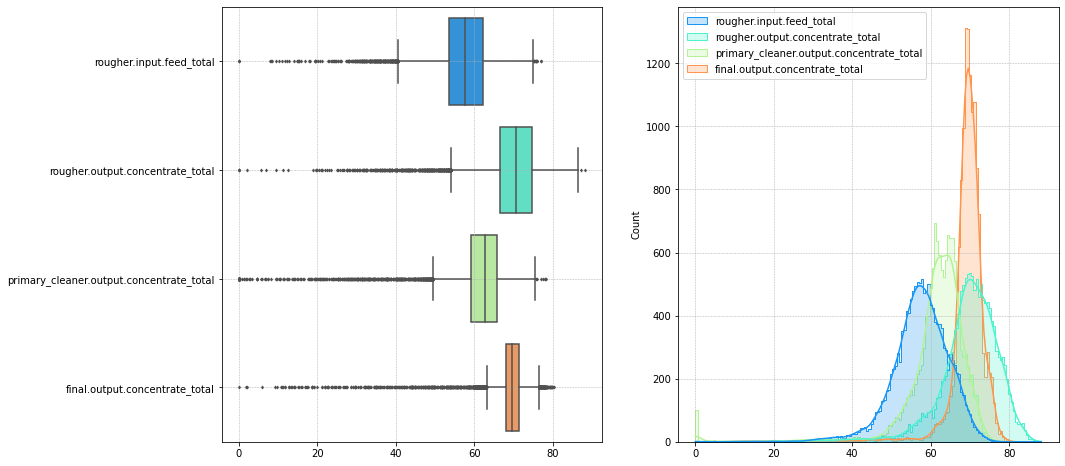

In [27]:
# Визуализация

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plt.subplot(1, 2, 1)
ax = sns.boxplot(data=df_train[['rougher.input.feed_total', 'rougher.output.concentrate_total',
                               'primary_cleaner.output.concentrate_total', 'final.output.concentrate_total']], 
                    fliersize=2, orient='h', palette='rainbow')
ax.grid(linewidth = 0.5, linestyle = '--')

plt.subplot(1, 2, 2)
ax = sns.histplot(df_train[['rougher.input.feed_total', 'rougher.output.concentrate_total',
                           'primary_cleaner.output.concentrate_total', 'final.output.concentrate_total']], 
                  kde=True, element='step', palette='rainbow')
ax.grid(linewidth = 0.5, linestyle = '--')

In [28]:
# Убедимся, что на графике не нули, а просто очень маленькие значения 

df_train['primary_cleaner.output.concentrate_total'].describe()

count    13757.000000
mean        61.274174
std          9.038257
min          0.040000
25%         59.276350
50%         62.630815
75%         65.839869
max         78.255313
Name: primary_cleaner.output.concentrate_total, dtype: float64

#### Вывод:

На всех стадиях, кроме финальной, суммарная концентрация веществ (`Au`, `Ag`, `Pb` и `Sol`) характеризуется приблизительно схожими по ширине интервалами разброса её значений относительно среднего, на финальной стадии - интервал более "узкий". Среднее значение суммарной концентрации колеблется в пределах от 57 до 69%. 

## Модель

Напишем функцию для вычисления итоговой `sMAPE`:

In [29]:
def smape(target, predictions):
    return (2 / (len(target))) * 100 * sum(abs(target - predictions) / (abs(target) + abs(predictions)))

In [30]:
def score_smape(rougher, final):
    return (0.25 * rougher + 0.75 * final) 

Реализуем процесс построения и обучения моделей. Возьмём модели: линейная регрессия и случайный лес.

In [31]:
# Восстанавливаем значение целевого признака в тестовой выборке

df_test_copy = df_test.merge(df_full, how='left')
df_test[['rougher.output.recovery', 'final.output.recovery']] = df_test_copy[['rougher.output.recovery',
                                                                              'final.output.recovery']]

In [32]:
# Список признаков, которых нет в тестовом наборе данных

unnecessary_features = list(set(df_train.columns) - set(df_test.columns))

In [33]:
# Удаляем признаки, не участв. в обучении модели

df_train.drop(columns=unnecessary_features, inplace=True)
df_train.drop('date', axis=1, inplace=True)
df_test.drop('date', axis=1, inplace=True)

In [34]:
# Проверка

display(df_train.shape, df_test.shape)

(13988, 54)

(4860, 54)

In [35]:
# Сохраним признаки и целевой признак (далее ц.п.) в отдельных переменных
# Введём обозначения: X - признаки, y - ц.п. (по аналогии с обозначениями выборок)
# Отдельно выделим признаки, ц.п. для обучающего набора данных и тестового набора данных

X_train = df_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'])

features = [col for col in df_train.columns if 'rougher' in col]
X_rougher_train = df_train[features].drop(columns='rougher.output.recovery')

y_rougher_train = df_train['rougher.output.recovery']
y_final_train = df_train['final.output.recovery']

X_test = df_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'])
X_rougher_test = df_test[features].drop(columns='rougher.output.recovery')

y_rougher_test = df_test['rougher.output.recovery']
y_final_test = df_test['final.output.recovery']

In [36]:
# Проверка

display(X_train.shape, X_test.shape)
display(y_rougher_train.shape, y_rougher_test.shape)
display(y_final_train.shape, y_final_test.shape)

(13988, 52)

(4860, 52)

(13988,)

(4860,)

(13988,)

(4860,)

#### Линейная регрессия

In [37]:
parameters = {
    'fit_intercept': [True, False], 
    'normalize': [True, False]
}

gs_lr_rougher = GridSearchCV(
                    estimator=LinearRegression(), 
                    param_grid=parameters, 
                    scoring=make_scorer(smape, greater_is_better=False), 
                    cv=3
)

In [38]:
%%time

gs_lr_rougher.fit(X_rougher_train, y_rougher_train); # обучаем GS на тренир. данных (первый таргет)

CPU times: total: 594 ms
Wall time: 578 ms


GridSearchCV(cv=9, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [39]:
parameters = {
    'fit_intercept': [True, False], 
    'normalize': [True, False]
}

gs_lr_final = GridSearchCV(
                estimator=LinearRegression(), 
                param_grid=parameters, 
                scoring=make_scorer(smape, greater_is_better=False), 
                cv=3
)

In [40]:
%%time

gs_lr_final.fit(X_train, y_final_train); # обучаем GS на тренир. данных (второй таргет)

CPU times: total: 1.81 s
Wall time: 1.18 s


GridSearchCV(cv=9, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [41]:
# Значение метрик 

score_rougher = abs(gs_lr_rougher.best_score_)
score_final = abs(gs_lr_final.best_score_)
score = score_smape(score_rougher, score_final)

print('Значение sMAPE для ц.п. rougher.output.recovery: {}'.format(round(score_rougher, 2)))
print('Значение sMAPE для ц.п. final.output.recovery: {}'.format(round(score_final, 2)))
print('Итоговое значение sMAPE: {}'.format(round(score, 2)))

Значение sMAPE для ц.п. rougher.output.recovery: 5.95
Значение sMAPE для ц.п. final.output.recovery: 9.53
Итоговое значение sMAPE: 8.63


In [42]:
# Параметры моделей

display(gs_lr_rougher.best_params_,
        gs_lr_final.best_params_)

{'fit_intercept': True, 'normalize': True}

{'fit_intercept': False, 'normalize': True}

#### Случайный лес

In [43]:
parameters = {
    'n_estimators': np.arange(60, 200, 20), 
    'max_depth': np.arange(5, 9)
}

gs_rfr_rougher = GridSearchCV(
                    estimator=RandomForestRegressor(random_state=STATE), 
                    param_grid=parameters, 
                    scoring=make_scorer(smape, greater_is_better=False), 
                    cv=3, verbose=10, n_jobs=-1
)

In [44]:
%%time

gs_rfr_rougher.fit(X_rougher_train, y_rougher_train); # обучаем GS на тренир. данных (первый таргет)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
CPU times: total: 8.03 s
Wall time: 3min 5s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7, 8]),
                         'n_estimators': array([ 60,  80, 100, 120, 140, 160, 180])},
             scoring=make_scorer(smape, greater_is_better=False), verbose=10)

In [45]:
parameters = {
    'n_estimators': np.arange(60, 200, 20), 
    'max_depth': np.arange(5, 9)
}

gs_rfr_final = GridSearchCV(
                    estimator=RandomForestRegressor(random_state=STATE), 
                    param_grid=parameters, 
                    scoring=make_scorer(smape, greater_is_better=False), 
                    cv=3, verbose=10, n_jobs=-1
)

In [46]:
%%time

gs_rfr_final.fit(X_train, y_final_train); # обучаем GS на тренир. данных (второй таргет)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
CPU times: total: 21.1 s
Wall time: 8min


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7, 8]),
                         'n_estimators': array([ 60,  80, 100, 120, 140, 160, 180])},
             scoring=make_scorer(smape, greater_is_better=False), verbose=10)

In [47]:
# Значение метрик 

score_rougher = abs(gs_rfr_rougher.best_score_)
score_final = abs(gs_rfr_final.best_score_)
score = score_smape(score_rougher, score_final)

print('Значение sMAPE для ц.п. rougher.output.recovery: {}'.format(round(score_rougher, 2)))
print('Значение sMAPE для ц.п. final.output.recovery: {}'.format(round(score_final, 2)))
print('Итоговое значение sMAPE: {}'.format(round(score, 2)))

Значение sMAPE для ц.п. rougher.output.recovery: 6.52
Значение sMAPE для ц.п. final.output.recovery: 9.96
Итоговое значение sMAPE: 9.1


Для обоих целевых признаков лучше себя показала модель линейной регрессии (подбор параметров по сетке установил наилучшие значения параметров модели ), значение итоговой метрики `sMAPE` составило 8.63%. Данные модели и возьмём для проверки качества на тестовой выборке. 

In [48]:
# В тестовой выборке содержатся пропуски, заполним их по аналогии с обучающей выборкой (предыдущим значением)

X_test = X_test.fillna(method='ffill')
X_rougher_test = X_rougher_test.fillna(method='ffill')

In [49]:
# Проверка

display(X_test.isna().sum(), X_rougher_test.isna().sum())

rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
rougher.input.floatbank11_sulfate       

rougher.input.feed_au                 0
rougher.input.feed_ag                 0
rougher.input.feed_pb                 0
rougher.input.feed_sol                0
rougher.input.feed_rate               0
rougher.input.feed_size               0
rougher.input.floatbank10_sulfate     0
rougher.input.floatbank10_xanthate    0
rougher.state.floatbank10_a_air       0
rougher.state.floatbank10_a_level     0
rougher.state.floatbank10_b_air       0
rougher.state.floatbank10_b_level     0
rougher.state.floatbank10_c_air       0
rougher.state.floatbank10_c_level     0
rougher.state.floatbank10_d_air       0
rougher.state.floatbank10_d_level     0
rougher.state.floatbank10_e_air       0
rougher.state.floatbank10_e_level     0
rougher.state.floatbank10_f_air       0
rougher.state.floatbank10_f_level     0
rougher.input.floatbank11_sulfate     0
rougher.input.floatbank11_xanthate    0
dtype: int64

In [50]:
# Получены модели с наилучшими параметрами, сохраним их в соотв. переменные

lr_rougher_model = gs_lr_rougher.best_estimator_
lr_final_model = gs_lr_final.best_estimator_

In [51]:
# Получаем предсказания

y_rougher_pred = lr_rougher_model.predict(X_rougher_test)
y_final_pred = lr_final_model.predict(X_test)

In [52]:
# Значение метрик 

score_rougher = smape(y_rougher_test, y_rougher_pred)
score_final = smape(y_final_test, y_final_pred)

score = score_smape(score_rougher, score_final)

print('Значение sMAPE для ц.п. rougher.output.recovery: {}'.format(round(score_rougher, 2)))
print('Значение sMAPE для ц.п. final.output.recovery: {}'.format(round(score_final, 2)))
print('Итоговое значение sMAPE: {}'.format(round(score, 2)))

Значение sMAPE для ц.п. rougher.output.recovery: 4.82
Значение sMAPE для ц.п. final.output.recovery: 8.06
Итоговое значение sMAPE: 7.25


Метрика `sMAPE` лучшей модели, рассчитанная на тестовом наборе данных, составила приблизительно 7.25%.

Для уверенности в том, что алгоритм качественно делает предсказание, сравним полученные результаты с предсказанием константной модели. Используем `DummyRegressor` со стратегией `constant` (исп. среднее значение):

In [53]:
dr_rought = DummyRegressor(strategy='constant', constant=y_rougher_pred.mean())
dr_rought.fit(X_rougher_train, y_rougher_train)
    
score_rougher = smape(y_rougher_test, dr_rought.predict(X_rougher_test))

In [54]:
dr_final = DummyRegressor(strategy='constant', constant=y_final_pred.mean())
dr_final.fit(X_train, y_final_train)
    
score_final = smape(y_final_test, dr_final.predict(X_test))

In [55]:
score = score_smape(score_rougher, score_final)

print('Значение sMAPE для ц.п. rougher.output.recovery: {}'.format(round(score_rougher, 2)))
print('Значение sMAPE для ц.п. final.output.recovery: {}'.format(round(score_final, 2)))
print('Итоговое значение sMAPE: {}'.format(round(score, 2)))

Значение sMAPE для ц.п. rougher.output.recovery: 6.11
Значение sMAPE для ц.п. final.output.recovery: 9.31
Итоговое значение sMAPE: 8.51


Видно, что значения `sMAPE` и итоговая метрика моделей линейной регрессии ниже, чем у констаных моделей, что свидетельствует об их адекватности.

## Вывод:

В процессе решения задачи предсказания коэффициента восстановления золота из золотосодержащей руды были подготовлены и проанализированы данные, описывающие этапы технологического процесса подготовки золотосодержащей руды. Проверена корректность расчета эффективности обогащения, выявлены особенности изменения ряда параметров в процессе очистки исходного концентрата.
Для предсказания эффективности обогащения использована пользовательская метрика `sMAPE`, учитывающая две величины: эффективность обогащения чернового концентрата и финального концентрата. Для решения задачи построены модели: линейная регрессия и случайный лес, подобраны оптимальные гиперпараметры моделей в разрезе минимизации метрики `sMAPE`. Лучшей моделью выбрана модель линейной регрессии, метрика `sMAPE` (на тестовом наборе данных) составила `7.25%`, проверка на адекватность прошла успешно.